<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [37]:
import re
import nltk
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


In [2]:
!pip install pandarallel

In [3]:
from pandarallel import pandarallel
from tqdm import tqdm
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
!pip install Pillow

In [5]:
!/opt/conda/bin/python -m pip install wordcloud

In [6]:
pip install --upgrade wordcloud pillow

Note: you may need to restart the kernel to use updated packages.


In [7]:
from wordcloud import WordCloud

In [8]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    print("При загрузке данных возникли ошибки")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [10]:
display(df.head())
display(df.tail())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [11]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Классы сильно не сбалансированы. На текущем этапе исправлять не будем, вернемся к этому если результаты обучения будут не удовлетворительными

In [13]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    tokens = word_tokenize(text)  
    tokens_pos = pos_tag(tokens) 
    lemmas = [wnl.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_pos if word not in stop_words]
    text = " ".join(lemmas)
    return text

In [16]:
df['text_lemma'] = df['text'].apply(preprocess_text)

In [17]:
df['text_lemma']

0         explanation edits make username hardcore metal...
1         aww match background colour seemingly stick th...
2         hey man really try edit war guy constantly rem...
3         make real suggestion improvement wonder sectio...
4                             sir hero chance remember page
                                ...                        
159287    second time ask view completely contradict cov...
159288    ashamed horrible thing put talk page 128 61 19 93
159289    spitzer umm theres actual article prostitution...
159290    look like actually put speedy first version de...
159291    really think understand come idea bad right aw...
Name: text_lemma, Length: 159292, dtype: object

In [18]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [19]:
df['text_lemma'][0]

'explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire 89 205 38 27'

In [20]:
text_raw = " ".join(df['text_lemma'])

In [21]:
wordcloud = WordCloud().generate(text_raw)

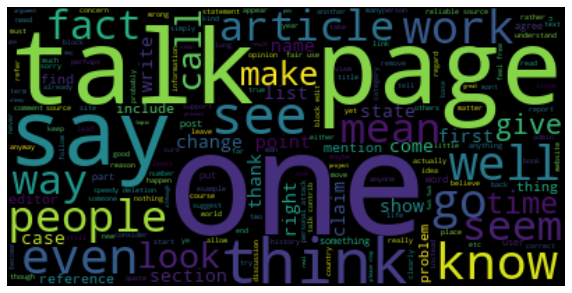

In [25]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
tokens = word_tokenize(text_raw)
fdist = FreqDist(tokens)

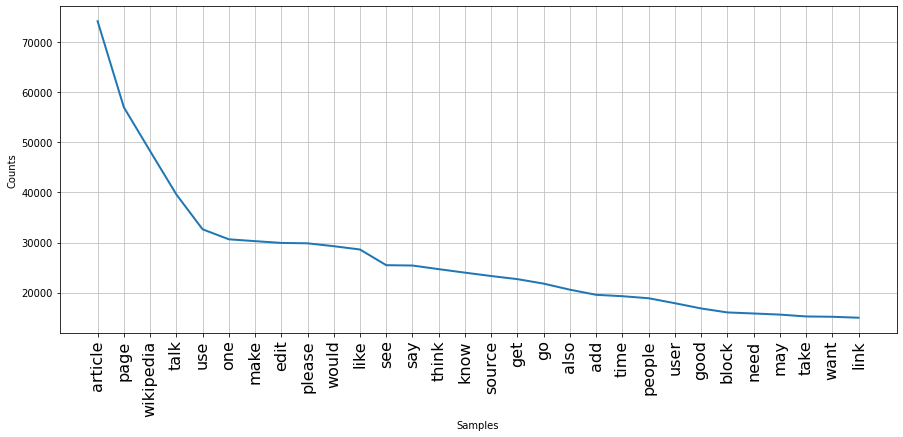

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [35]:
plt.figure(figsize=(15, 6))
plt.tick_params(axis='x', labelsize=16)
fdist.plot(30,cumulative=False)

**Вывод**
- Корпус текстов на английском языке.
- Данные сильно не сбалансированы, но пока исправлять не будет, вернемся к этому если результаты обучения будут не удовлетворительным.
- Провели предварительную обработку текста, лематизировали, удалили лишние символы и стопслова.

## Обучение

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['text_lemma'], df['toxic'], test_size=0.2, shuffle=True, random_state=42)

In [43]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

 В качестве метрики выберем метрику f1, т.к. классы не сбалансированы.

Проверим на простой модели логистической регрессии.

In [29]:
#model_lr = LogisticRegression(random_state=42, class_weight='balanced')

In [48]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [49]:
param_grid = {
    'lr__C': [1], 
    'lr__max_iter': [100]
}

In [50]:
#grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='f1', verbose=1)

In [51]:
grid_search_lr = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='f1', verbose=1)

In [53]:
grid_search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'lr__C': [1], 'lr__max_iter': [100]}, scoring='f1',
             verbose=1)

In [54]:
print("F1 (val) for RandomForest:", grid_search_lr.best_score_)

F1 (val) for RandomForest: 0.7462999618683758


Проверм модель случайного леса.

In [35]:
#model_rfc = RandomForestClassifier(random_state=42)

In [55]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [56]:
param_grid = {
    'rfc__n_estimators': [100],
    'rfc__max_depth': [None]  
}

In [57]:
#grid_search_rfc = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=3, scoring='f1', verbose=1)

In [58]:
grid_search_rfc = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='f1', verbose=1)

In [59]:
grid_search_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__max_depth': [None], 'rfc__n_estimators': [100]},
             scoring='f1', verbose=1)

In [60]:
print("F1 (val) for RandomForest:", grid_search_rfc.best_score_)

F1 (val) for RandomForest: 0.6941024154571535


Проверим модель LightGBM

In [61]:
#model_lgbm = lgb.LGBMClassifier(random_state=42)

In [63]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgb', lgb.LGBMClassifier(random_state=42))
])

In [64]:
param_grid = {
    'lgb__num_leaves': [31], 
    'lgb__max_depth': [-1],  
    'lgb__learning_rate': [0.1] 
}

In [65]:
#grid_search_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='f1', cv=3, verbose=1)

In [66]:
grid_search_lgbm = GridSearchCV(pipeline, param_grid=param_grid, scoring='f1', cv=3, verbose=1)

In [67]:
grid_search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lgb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgb__learning_rate': [0.1], 'lgb__max_depth': [-1],
                         'lgb__num_leaves': [31]},
             scoring='f1', verbose=1)

In [68]:
print("F1 (val) for LightGBM:", grid_search_lgbm.best_score_)

F1 (val) for LightGBM: 0.7523667185933364


У модели LightGBM оказалась самая высока метрика f1 на валидационных данных, проверим модель на тестовых данных.

In [72]:
model_lgb = lgb.LGBMClassifier(num_leaves=31, max_depth=-1, learning_rate=0.1, random_state=42)

In [73]:
model_lgb.fit(X_train_vec, y_train)

LGBMClassifier(random_state=42)

In [74]:
y_pred = model_lgb.predict(X_test_vec)

In [75]:
f1 = f1_score(y_test, y_pred)
print(f"F1-мера: {f1}")

F1-мера: 0.7512355848434927


**Выводы** 
- Было обучено три модели: логистическая регрессия, случайный лес и LightGBM
- На валидационных данных у LightGBM оказалась лучшая метрика f1 = 0.752
- на тестовых данных логистическая регрессия показала результат 0.751

## Выводы

Была проведена работа с корпусом англоязычных текстов из 159 тыс. записей. Данные сильно не сбалансированы, на это не помешало получить требуемый уровень метрики. В качестве метрики была выбрана f1, опять же из-за того, что данные не сбалансированы. Провели предварительную обратботку текста: лематизировали, удалили лишние символы и стопслова. Было обучено три модели: LogisticRegression, RandomForest, LightGBM. На валидационных данных лучший результак показала логистическая регрессия - 0.753, на тестовых данных - 0.754, что говорит о том, что модель не является переобученной или недообученной.